In [7]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import pathlib
from tensorflow.keras import layers, models
import tensorflow_model_optimization as tfmot


print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.13.0


In [8]:
def create_synthetic_database():
    # Load MNIST data
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

    class_names = ['plastic', 'paper', 'glass']

    # Reshape grayscale images to (28, 28, 1)
    x_train = x_train.reshape(-1, 28, 28, 1)
    x_test = x_test.reshape(-1, 28, 28, 1)

    # Resize to (32, 32)
    x_train = tf.image.resize(x_train, [32, 32])
    x_test = tf.image.resize(x_test, [32, 32])

    # Convert to 3 channels (RGB)
    x_train = tf.repeat(x_train, repeats=3, axis=-1)
    x_test = tf.repeat(x_test, repeats=3, axis=-1)

    # Subsample and normalize
    x_train = x_train[:3000] / 255.0
    y_train = y_train[:3000] % 3

    x_test = x_test[:500] / 255.0
    y_test = y_test[:500] % 3

    # One-hot encode labels
    y_train = tf.keras.utils.to_categorical(y_train, 3)
    y_test = tf.keras.utils.to_categorical(y_test, 3)

    return (x_train, y_train), (x_test, y_test), class_names

# Call the function
(x_train, y_train), (x_test, y_test), class_names = create_synthetic_database()

print(f"Training data shape: {x_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Classes: {class_names}")


Training data shape: (3000, 32, 32, 3)
Training labels shape: (3000, 3)
Classes: ['plastic', 'paper', 'glass']


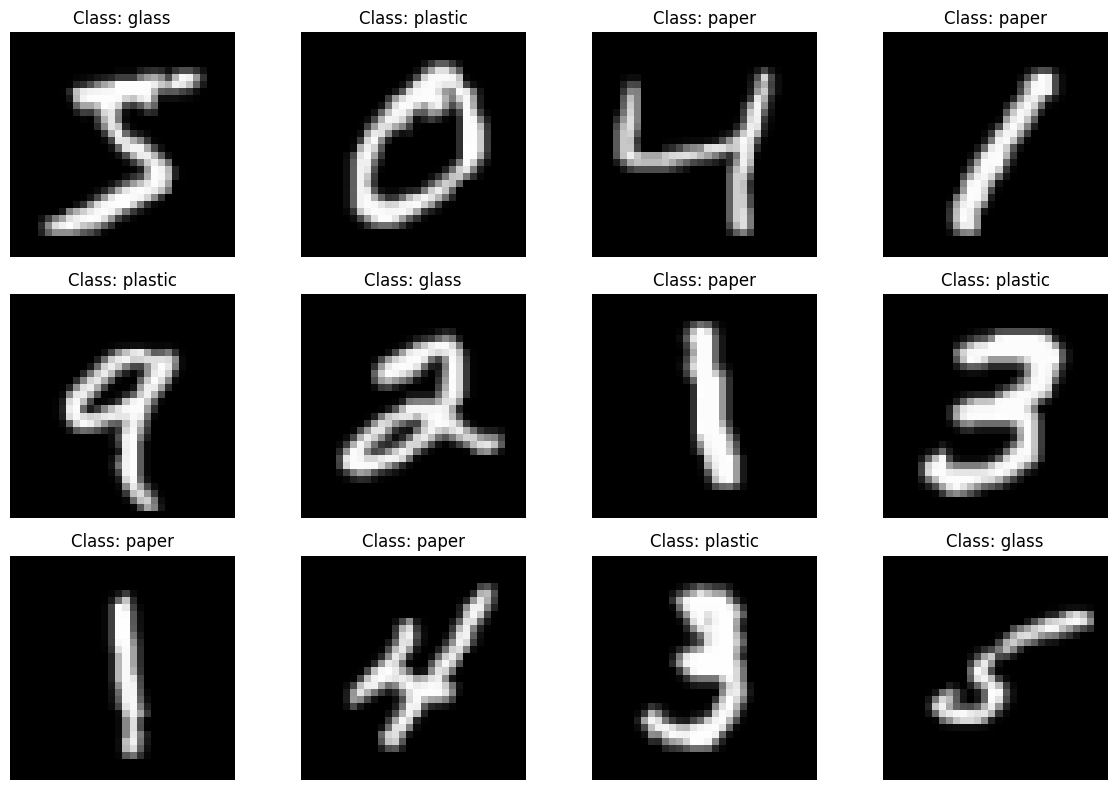

In [9]:
# Visualize some samples from the dataset
plt.figure(figsize=(12, 8))
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.imshow(x_train[i])
    plt.title(f'Class: {class_names[np.argmax(y_train[i])]}')
    plt.axis('off')
plt.tight_layout()
plt.show()


In [10]:
# model creation
def create_edge_model(input_shape=(32, 32, 3), num_classes=3):
    """
    Create a lightweight CNN model optimized for edge devices
    """
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

# Create and display model
model = create_edge_model()
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 30, 30, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 13, 13, 64)        256       
 chNormalization)                                                
                                                        

In [13]:
# Clear previous model state
tf.keras.backend.clear_session()

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
print("Starting model training...")
history = model.fit(
    x_train, y_train,  
    batch_size=32,
    epochs=5, 
    validation_data=(x_test, y_test),
    verbose=1
)


Starting model training...
Epoch 1/5
94/94 [==============================] - 43s 250ms/step - loss: 0.5589 - accuracy: 0.7860 - val_loss: 2.2469 - val_accuracy: 0.3420
Epoch 2/5
94/94 [==============================] - 20s 210ms/step - loss: 0.2417 - accuracy: 0.9173 - val_loss: 2.8747 - val_accuracy: 0.3420
Epoch 3/5
94/94 [==============================] - 19s 205ms/step - loss: 0.1763 - accuracy: 0.9370 - val_loss: 1.6937 - val_accuracy: 0.4020
Epoch 4/5
94/94 [==============================] - 9s 89ms/step - loss: 0.1473 - accuracy: 0.9460 - val_loss: 0.5011 - val_accuracy: 0.7920
Epoch 5/5
94/94 [==============================] - 12s 123ms/step - loss: 0.1175 - accuracy: 0.9587 - val_loss: 0.1835 - val_accuracy: 0.9280
